## Imports

In [89]:
import numpy as np
import subprocess
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import array
import csv
import time

# import deap packages required
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import pandas as pd

## Load test instance 

In [90]:
myinst = "./artGalleryTestInstances/rooms.csv"

instance_file = myinst
instance_size  = 100
num_cells = instance_size * instance_size # total number of cells in the grid

# create a grid that specifies the walls that can be used later to check that no cameras are positioned on walls
walls = np.zeros(instance_size * instance_size)

with open(myinst) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter = ',')
    for line in csv_reader:
        column = int(line[0])
        row = int(line[1])
        oneD_index = (row * instance_size) + column
        walls[oneD_index] = 1

## Executables wrappers

In [91]:
path_binary = "ECO-Coursework-Executables/bit_cam_napier.exe"
path_binary_vis = "ECO-Coursework-Executables/bit_cam_napier_visualisation.exe"

# Do NOT modify this code - this calls an external binary with a solution
def objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary,str(instance_size),str(nb_cameras)]+params+[instance_file]
    s = subprocess.check_output(cmd)
    return float(s)


# Do NOT modify: this checks whether a camera is positioned on top of wall in a solution
def check_walls(solution, inst):
    clashes=0
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i]==1):
            clashes+=1
            
    return(clashes)

## Individual initialisation

In [92]:
max_cameras = 300
compressed_grid_size = 50
compressed_cells = compressed_grid_size * compressed_grid_size
full_grid_size = 100
full_grid_cells = full_grid_size * full_grid_size

def generate_individual():
    nb_cam = random.randint(1, max_cameras)
    individual = np.zeros(compressed_cells)
    # select which positions should have cameras
    indexes = random.sample(range(0, compressed_cells), nb_cam)
    for j in indexes:
        individual[j] = 1

    if len(cameras_on_walls(individual)) > 0:
        repair_solution(individual)

    return individual

def convert_compressed_to_full(individual):
    solution = [0] * full_grid_cells

    for i in range(len(individual)):
        if individual[i] == 1:
            # Determine the row and column in the compressed grid
            row_compressed = i // compressed_grid_size
            col_compressed = i % compressed_grid_size
            
            # Calculate the top-left index of the corresponding 2x2 block in the full grid
            top_left_index = (row_compressed * 2 * full_grid_size) + (col_compressed * 2)
            
            # Set the top-left cell in the 2x2 block
            solution[top_left_index] = 1

    return solution


## Repair function

In [93]:
def cameras_on_walls(solution):
    positions = []
    for i in range(0, len(solution)):
        if (walls[i] == 1 and solution[i] == 1):
            positions.append(i)
            
    return(positions)

# delete all cameras that are on the walls 
def repair_solution(solution):
    clash_positions = cameras_on_walls(solution)

    prob_of_repair = 0.7
    for pos in clash_positions:
        prob = random.randint(0, 1)
        if prob < prob_of_repair:
            solution[pos] = 0

## Evaluation function

In [94]:
# this is the eval function called from DEAP: you can modify this to adapt the fitness for invalid solutions. The fitness of a valid solution
# is obtained by calling the binary executable

# This is the function where you will likely do most work!

def eval_function(individual):
    solution = [] # list of length equivalent to number of cells in the grid, where each value is 0 or 1
    total_cameras = 99999
    fitness = total_cameras

    # convert individual to the solution list - this depends on the representation
    solution = convert_compressed_to_full(individual)
    
    # check if cameras on walls
    if instance_file == "":
        cameras_on_walls = 0
    else:
        cameras_on_walls = check_walls(solution, instance_file) 

    if cameras_on_walls > 0:
        repair_solution(solution)
        individual = solution

    total_cameras = np.sum(solution)

    invalid_penalty=20000
    not_covered_penalty_factor = 15000

    # assign fitness after checking for validity
    if  total_cameras < 1:
        fitness = invalid_penalty # no cameras

    else:
        # only call this if the solution is not invalid
        coverage = objective_function(solution, instance_size, total_cameras, instance_file)
    
        if coverage < 0.99:
            # decide how to penalise this solution which does not provide 100% coverage 
            fitness = not_covered_penalty_factor  # you should modify this
        else:
            fitness = total_cameras  # fitness is the number of cameras used (minimise)

    # print("evaluated individual with " + str(total_cameras) + " cameras, elapsed: " + str(total_time))
    #print("cameras on walls " + str(cameras_on_walls) + ", total cameras: " + str(total_cameras) + ", fitness: " + str(fitness))
    return fitness,

## Setup the EA

In [ ]:
population = 50
generations = 50
hall_of_fame_size = 1 # How many best individuals to keep

# SETUP THE EA
# define the fitness class and creare an individual class
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


# create a toolbox
toolbox = base.Toolbox()

toolbox.register("individual", lambda: creator.Individual(generate_individual()))

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# register all operators we need with the toolbox
toolbox.register("evaluate", eval_function)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=2)

c:\Users\julka\anaconda3\envs\eco\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\julka\anaconda3\envs\eco\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Simple EA with elitism

In [96]:
# Taken directly from: https://github.com/PacktPublishing/Hands-On-Genetic-Algorithms-with-Python/blob/master/Chapter05/elitism.py

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


## Main EA definition

In [97]:

def main():
    
    # choose a population size: e.g. 200
    pop = toolbox.population(n=population)
    
    # keep track of the single best solution found
    hof = tools.HallOfFame(hall_of_fame_size)
 
    # create a statistics object: we can log what ever statistics we want using this. We use the numpy Python library
    # to calculate the stats and label them with convenient labels
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    # run the algorithm: we need to tell it what parameters to use
    # cxpb = crossover probability; mutpb = mutation probability; ngen = number of iterations
    pop, log = eaSimpleWithElitism(pop, toolbox, cxpb=0.6, mutpb=0.05, ngen=generations, stats=stats, halloffame=hof, verbose=True)
    
    return pop, log, hof

## Run the EA

In [ ]:
runs = [["Best", "Generation", "Time"]]
for run in range(0, 10):
    start = time.time()
    pop, log, hof = main()
    stop = time.time()

    run_time = stop - start

    best = hof[0].fitness.values[0]   # best fitness found is stored at index 0 in the hof list

    # look in the logbook to see what generation this was found at
    min = log.select("min")  # max fitness per generation stored in log

    for i in range(generations):  # set to ngen
            fit = min[i]
            if fit == best:
                break        

    runs.append([best, i, run_time])  

    with open("output.csv", mode = "a", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([best,i, run_time])      
    
    print("min fitness found is %s at generation %s" % (best, i))



gen	nevals	avg    	std    	min	max  
0  	50    	4323.58	6658.15	71 	15000
1  	28    	1634.72	4455.51	68 	15000
2  	30    	417.72 	2083.71	67 	15000
3  	25    	394.4  	2086.78	65 	15000
4  	33    	386.94 	2087.95	65 	15000
5  	36    	380.8  	2088.73	59 	15000
6  	26    	971.92 	3544.24	59 	15000
7  	34    	68.16  	19.7316	59 	203  
8  	33    	964.58 	3546.06	59 	15000
9  	27    	964.86 	3546.02	57 	15000
10 	21    	663.1  	2926.6 	57 	15000
11 	29    	662.36 	2926.74	57 	15000
12 	33    	70.46  	32.2194	57 	187  
13 	26    	63.9   	20.6429	56 	169  
14 	30    	363.02 	2091.16	54 	15000
15 	28    	963.96 	3546.29	54 	15000
16 	29    	665.78 	2926.16	54 	15000
17 	34    	663.48 	2926.65	54 	15000
18 	28    	656.4  	2927.91	54 	15000
19 	32    	957.84 	3547.76	54 	15000
20 	35    	359.38 	2091.63	52 	15000
21 	28    	1251.38	4054.25	52 	15000
22 	30    	958.58 	3547.6 	52 	15000
23 	24    	360.32 	2091.51	52 	15000
24 	31    	57.66  	17.1086	52 	177  
25 	27    	64.3   	32.3915	52 	184  
2

## Visualise solution and statistics

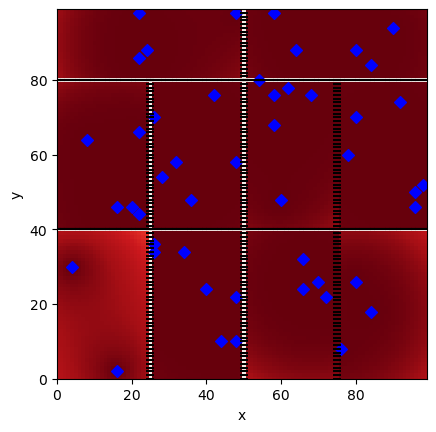

In [99]:
# Run this cell to define the functions
def solution_converter(index, instance_size):
    counter = 0
    for i in range(instance_size):
        for j in range(instance_size):
            if (counter == index):
                return i,j
            else:
                counter+=1

# assumes path_binary is already set 
def visualise_objective_function(x, instance_size, nb_cameras, instance_file):
    params = ['%.16g' % a for a in x]
    cmd = [path_binary_vis,str(instance_size),str(nb_cameras)]+params+[instance_file]
    with open("temp_results.csv",'w') as fd:
        s = subprocess.call(cmd, stdout=fd)
    # Plotting the probability of detection
    data = pd.read_csv("temp_results.csv")
    values = np.array(data["value"])
    values[values < 0.5] = 0
    values = values.reshape(instance_size,instance_size)
    plt.imshow(values,cmap="Reds")
    # Plotting cameras
    cameras_indices = [index for (index, item) in enumerate(list(x)) if item == 1]
    for c in cameras_indices:
        x,y = solution_converter(c, instance_size=instance_size)
        plt.scatter(y,x,c="blue",marker="D")
    # Plotting walls (if any)
    if (instance_file != ""):
        walls = pd.read_csv(instance_file,header=None)
        plt.scatter(walls[1],walls[0],c="black", marker="_")
    plt.xlim(0,instance_size-1)
    plt.xlabel("x")
    plt.ylim(0,instance_size-1)
    plt.ylabel("y")
    plt.show()
    
# Here we just create a random solution for a 100x100 grid with two cameras at random positions
# you can experiment to see what different solutions look like

final_solution = hof[0]
final_solution = convert_compressed_to_full(final_solution)

actual_cameras=sum(final_solution)  # need to pass the actual numbers of cameras in the solution, regardless of whether it is valid

# choose an empty grid
#visualise_objective_function(sol, instance_size= 100, nb_cameras=2, instance_file="")

# choose a layout


visualise_objective_function(final_solution, instance_size=instance_size, nb_cameras=actual_cameras, instance_file=myinst)


C:\Users\julka\AppData\Local\Temp\ipykernel_1456\2919038694.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
C:\Users\julka\AppData\Local\Temp\ipykernel_1456\2919038694.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
C:\Users\julka\AppData\Local\Temp\ipykernel_1456\2919038694.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")


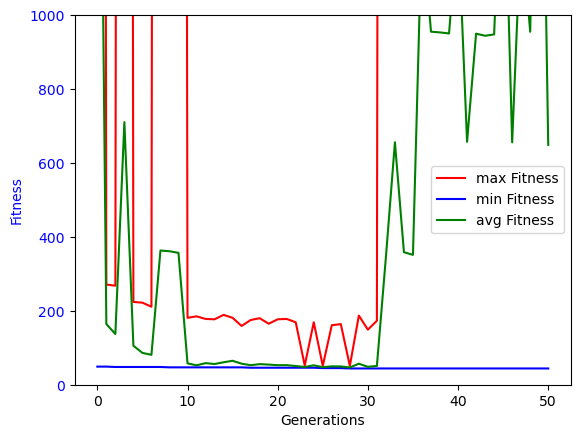

In [100]:
# code for plotting

gen = log.select("gen")
fit_max = log.select("max")
fit_min = log.select("min")
fit_avg = log.select("avg")

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")
ax1.set_ylim(0,1000)
    
lns = line1+line2+line3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")
